# 基于`LSTM模型`预测未来一个交易日`开盘价的涨跌`

## 1. 数据预处理
### 1.1 根据股票代码划分数据

In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np

# 全局变量
cols = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20] # 选取属性
feanum=len(cols) - 3 # 特征数量
window=5 # 时间窗设置

/home/tianhao/env4tiho_py36/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
Duplicate key in file PosixPath('/home/tianhao/env4tiho_py36/lib/python3.6/site-packages/matplotlib/mpl-data/matplotlibrc'), line 400 ('axes.unicode_minus: True  # use Unicode for the minus symbol rather than hyphen.  See')
/home/tianhao/env4tiho_py36/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


* **训练集**

In [2]:
train_df = pd.read_csv("../data/biClsData/trainData2.csv", usecols=cols)
# train_df = pd.read_csv("../data/trainData.csv")
train_stocks_code = train_df["kdcode"].unique()
train_stocks_num = len(train_stocks_code)

"训练集股票数量：",train_stocks_num

('训练集股票数量：', 3604)

In [3]:
train_df

,dt,kdcode,volume,turnover,turn,vwap,vwap_mean3,vwap_mean5,vwap_mean10,vwap_mean20,...,chg_mean3,chg_mean5,chg_mean10,adj_open,open_mean3,open_mean5,open_mean10,high_low,close_open,label
0,2016-01-04,000004.SZ,0.032267,0.129146,0.031824,0.488994,0.488731,0.488527,0.488106,0.487706,...,0.025756,0.025756,0.025756,0.936769,0.936935,0.936933,0.936923,0.558879,0.299335,0.0
1,2016-01-05,000004.SZ,0.054882,0.199040,0.054132,0.442429,0.465433,0.465220,0.464779,0.464362,...,0.028880,0.028880,0.028880,0.764645,0.850856,0.850852,0.850829,0.391955,0.653598,0.0
2,2016-01-06,000004.SZ,0.029884,0.109187,0.029474,0.445773,0.458782,0.458567,0.458121,0.457698,...,0.034311,0.034311,0.034311,0.787185,0.829678,0.829673,0.829647,0.211296,0.616759,0.0
3,2016-01-07,000004.SZ,0.006455,0.021836,0.006364,0.412143,0.433148,0.446824,0.446368,0.445936,...,0.034308,0.032170,0.032170,0.785136,0.779124,0.818571,0.818544,0.342300,0.382222,0.0
4,2016-01-08,000004.SZ,0.043489,0.141737,0.042894,0.396876,0.417954,0.436721,0.436257,0.435817,...,0.038314,0.034540,0.034540,0.716081,0.762933,0.798096,0.798065,0.503942,0.602638,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2822607,2019-12-25,688389.SH,0.048334,0.074939,0.115043,0.185098,0.181560,0.183117,0.180226,0.177183,...,0.042325,0.042269,0.043423,0.053311,0.053109,0.053716,0.052761,0.009690,0.581775,0.0
2822608,2019-12-26,688389.SH,0.049122,0.076895,0.116914,0.186948,0.183438,0.183236,0.180975,0.177456,...,0.046297,0.043617,0.044086,0.053833,0.052958,0.053416,0.052865,0.008972,0.584694,0.0
2822609,2019-12-27,688389.SH,0.042794,0.066764,0.101831,0.186296,0.185652,0.183075,0.182022,0.177687,...,0.043701,0.042475,0.043696,0.054877,0.054002,0.053577,0.053161,0.011664,0.576456,0.0
2822610,2019-12-30,688389.SH,0.027754,0.042335,0.066054,0.181994,0.184616,0.183210,0.182501,0.177728,...,0.042571,0.043833,0.043392,0.052789,0.053828,0.053277,0.053318,0.009331,0.582087,1.0


In [4]:
# 根据股票代码划分数据
for i, stock_i in enumerate(tqdm(train_stocks_code)):
    stock_i_data = train_df[train_df['kdcode'].isin([stock_i])]
    exec("train_df%s = stock_i_data" % i)

100%|██████████| 3604/3604 [02:03<00:00, 29.07it/s]


* **测试集**

In [5]:
test_df = pd.read_csv("../data/biClsData/testData2.csv", usecols=cols)
# test_df = pd.read_csv("../data/testData.csv")
test_stocks_code = test_df["kdcode"].unique()
test_stocks_num = len(test_stocks_code)

"测试集股票数量：",test_stocks_num

('测试集股票数量：', 3790)

In [6]:
# 根据股票代码划分数据
for i, stock_i in enumerate(tqdm(test_stocks_code)):
    stock_i_data = test_df[test_df['kdcode'].isin([stock_i])]
    exec("test_df%s = stock_i_data" % i)

100%|██████████| 3790/3790 [00:59<00:00, 63.19it/s]


### 1.2. 将原始数据改造为LSTM网络的输入
分割出window个时间窗的数据为输入的`X`

紧接着的那条数据为标签`Y`

因此需要将每只股票的数据按照时间(日期)分割成`window + 1`长度的数据

* **训练集**

In [7]:
train_df

,dt,kdcode,volume,turnover,turn,vwap,vwap_mean3,vwap_mean5,vwap_mean10,vwap_mean20,...,chg_mean3,chg_mean5,chg_mean10,adj_open,open_mean3,open_mean5,open_mean10,high_low,close_open,label
0,2016-01-04,000004.SZ,0.032267,0.129146,0.031824,0.488994,0.488731,0.488527,0.488106,0.487706,...,0.025756,0.025756,0.025756,0.936769,0.936935,0.936933,0.936923,0.558879,0.299335,0.0
1,2016-01-05,000004.SZ,0.054882,0.199040,0.054132,0.442429,0.465433,0.465220,0.464779,0.464362,...,0.028880,0.028880,0.028880,0.764645,0.850856,0.850852,0.850829,0.391955,0.653598,0.0
2,2016-01-06,000004.SZ,0.029884,0.109187,0.029474,0.445773,0.458782,0.458567,0.458121,0.457698,...,0.034311,0.034311,0.034311,0.787185,0.829678,0.829673,0.829647,0.211296,0.616759,0.0
3,2016-01-07,000004.SZ,0.006455,0.021836,0.006364,0.412143,0.433148,0.446824,0.446368,0.445936,...,0.034308,0.032170,0.032170,0.785136,0.779124,0.818571,0.818544,0.342300,0.382222,0.0
4,2016-01-08,000004.SZ,0.043489,0.141737,0.042894,0.396876,0.417954,0.436721,0.436257,0.435817,...,0.038314,0.034540,0.034540,0.716081,0.762933,0.798096,0.798065,0.503942,0.602638,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2822607,2019-12-25,688389.SH,0.048334,0.074939,0.115043,0.185098,0.181560,0.183117,0.180226,0.177183,...,0.042325,0.042269,0.043423,0.053311,0.053109,0.053716,0.052761,0.009690,0.581775,0.0
2822608,2019-12-26,688389.SH,0.049122,0.076895,0.116914,0.186948,0.183438,0.183236,0.180975,0.177456,...,0.046297,0.043617,0.044086,0.053833,0.052958,0.053416,0.052865,0.008972,0.584694,0.0
2822609,2019-12-27,688389.SH,0.042794,0.066764,0.101831,0.186296,0.185652,0.183075,0.182022,0.177687,...,0.043701,0.042475,0.043696,0.054877,0.054002,0.053577,0.053161,0.011664,0.576456,0.0
2822610,2019-12-30,688389.SH,0.027754,0.042335,0.066054,0.181994,0.184616,0.183210,0.182501,0.177728,...,0.042571,0.043833,0.043392,0.052789,0.053828,0.053277,0.053318,0.009331,0.582087,1.0


In [8]:
# 分割数据
trainResult = []
for i in tqdm(range(train_stocks_num)): # 遍历训练集所有股票的DataFrame
    exec("trainData = train_df%s.values" % i)
    sequence_length = window + 1
    for index in range(len(trainData) - sequence_length + 1):
        trainResult.append(trainData[index: index + sequence_length])

trainResult = np.array(trainResult)
trainResult.shape

100%|██████████| 3604/3604 [00:03<00:00, 1053.62it/s]


(2804607, 6, 21)

In [9]:
# 保存分割后每条数据的日期
train_date = trainResult[:,-1,0]
len(train_date)

2804607

* **测试集**

In [10]:
testResult = []
for i in tqdm(range(test_stocks_num)): # 遍历训练集所有股票的DataFrame
    exec("testData = test_df%s.values" % i)
    sequence_length = window + 1
    for index in range(len(testData) - sequence_length + 1):
        testResult.append(testData[index: index + sequence_length])

testResult = np.array(testResult)
testResult.shape

100%|██████████| 3790/3790 [00:01<00:00, 2561.50it/s]


(1280967, 6, 21)

In [11]:
# 保存分割后每条数据的日期
test_date = testResult[:,-1,0]
len(test_date)

1280967

**分割出X**

In [12]:
X_train = trainResult[:, :-1, 2:-1]
X_test = testResult[:, :-1, 2:-1]
X_train = X_train.astype('float64')
X_test = X_test.astype('float64')
print("训练集X：" + str(X_train.shape))
print("测试集X：" + str(X_test.shape))

训练集X：(2804607, 5, 18)
测试集X：(1280967, 5, 18)


**分割出Y**

In [13]:
Y_train = trainResult[:, window, -1]
Y_train.shape

(2804607,)

In [14]:
Y_test = testResult[:, window, -1]
Y_test.shape

(1280967,)

In [15]:
Y_train = Y_train.astype('float64')
Y_test = Y_test.astype('float64')
# Y_train[0:5]
# Y_test[0:5]

## 3. 模型构建与训练

In [16]:
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.layers.recurrent import GRU
from keras.callbacks import EarlyStopping
import tensorflow as tf
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

#建立、训练模型过程
d = 0.001
model = Sequential()#建立层次模型
model.add(LSTM(64, input_shape=(window, feanum), return_sequences=True))#建立LSTM层
model.add(Dropout(d))#建立的遗忘层
model.add(LSTM(32, input_shape=(window, feanum), return_sequences=False))#建立LSTM层
model.add(Dropout(d))#建立的遗忘层

model.add(Dense(16,kernel_initializer='uniform',activation='relu'))   #建立全连接层     
model.add(Dense(1, kernel_initializer = "uniform", activation = "sigmoid"))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [17]:
for i in range(6):
    history = model.fit(X_train, Y_train, epochs = 5, batch_size = 512, validation_split = 0.1) #训练模型epochs次
    # 在测试集上的预测
    Y_test_predict=model.predict(X_test)[:,0]
    Y_test=Y_test
    # 计算测试集的准确率
    test_predict = Y_test_predict.copy()
    test_predict[Y_test_predict > 0.5] = 1
    test_predict[Y_test_predict <= 0.5] = 0
    result = metrics.accuracy_score(Y_test, test_predict)
    print('测试集正确率:',result)

Epoch 1/5
4930/4930 [==============================] - 217s 39ms/step - loss: 0.6913 - accuracy: 0.5216 - val_loss: 0.6894 - val_accuracy: 0.5303
Epoch 2/5
4930/4930 [==============================] - 186s 38ms/step - loss: 0.6895 - accuracy: 0.5312 - val_loss: 0.6880 - val_accuracy: 0.5334
Epoch 3/5
4930/4930 [==============================] - 188s 38ms/step - loss: 0.6884 - accuracy: 0.5343 - val_loss: 0.6877 - val_accuracy: 0.5344
Epoch 4/5
4930/4930 [==============================] - 210s 43ms/step - loss: 0.6875 - accuracy: 0.5359 - val_loss: 0.6865 - val_accuracy: 0.5380
Epoch 5/5
4930/4930 [==============================] - 233s 47ms/step - loss: 0.6868 - accuracy: 0.5371 - val_loss: 0.6867 - val_accuracy: 0.5332
测试集正确率: 0.5236551761286591
Epoch 1/5
4930/4930 [==============================] - 218s 44ms/step - loss: 0.6860 - accuracy: 0.5391 - val_loss: 0.6860 - val_accuracy: 0.5385
Epoch 2/5
4930/4930 [==============================] - 253s 51ms/step - loss: 0.6853 - accuracy: 

In [18]:
#总结模型
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 64)             21248     
_________________________________________________________________
dropout (Dropout)            (None, 5, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 34,209
Trainable params: 34,209
Non-trainable params: 0
____________________________________________________

## 4. 模型训练结果
* 训练集

In [19]:
#在训练集上的拟合结果
Y_train_predict = model.predict(X_train)[:,0]
Y_train = Y_train

Text(0.5, 1.0, 'Train Data')

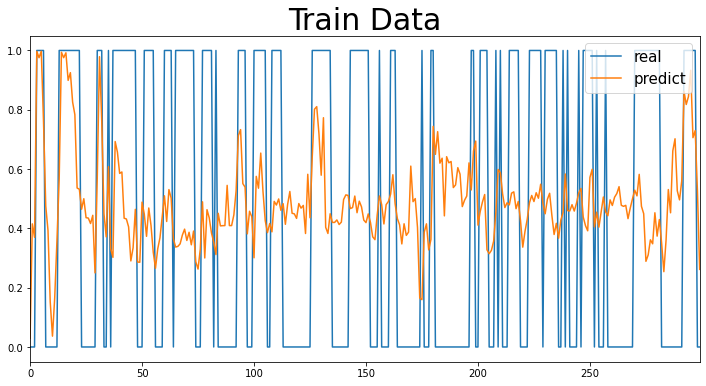

In [20]:
import matplotlib.pyplot as plt

draw=pd.concat([pd.DataFrame(Y_train),pd.DataFrame(Y_train_predict)],axis=1)
draw.iloc[:300,0].plot(figsize=(12,6))
draw.iloc[:300,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
plt.title("Train Data",fontsize='30') #添加标题
#展示在训练集上的表现

* 测试集

In [21]:
#在测试集上的预测
Y_test_predict=model.predict(X_test)[:,0]
Y_test=Y_test

Text(0.5, 1.0, 'Test Data')

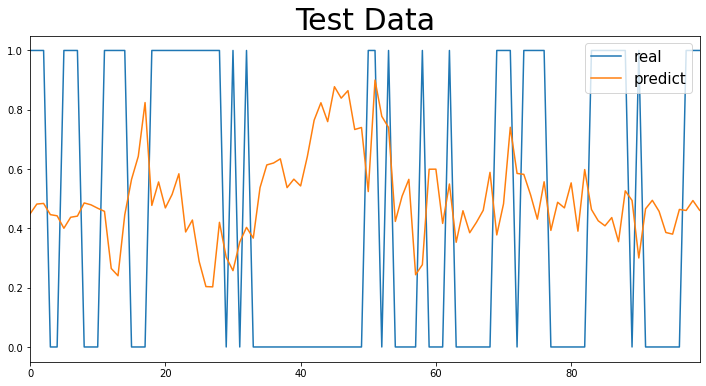

In [22]:
draw=pd.concat([pd.DataFrame(Y_test),pd.DataFrame(Y_test_predict)],axis=1);
draw.iloc[:100,0].plot(figsize=(12,6))
draw.iloc[:100,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
plt.title("Test Data",fontsize='30') #添加标题
# 展示在测试集上的表现

In [23]:
txt = np.zeros(len(Y_test))
test_predict = Y_test_predict.copy()
test_predict[Y_test_predict > 0.5] = 1
test_predict[Y_test_predict <= 0.5] = 0

train_predict = Y_train_predict.copy()
train_predict[Y_train_predict > 0.5] = 1
train_predict[Y_train_predict <= 0.5] = 0

result = metrics.accuracy_score(Y_test, test_predict)
'测试集正确率:',result

('测试集正确率:', 0.5318692831275122)

* 训练过程Loss,Accuracy的变化

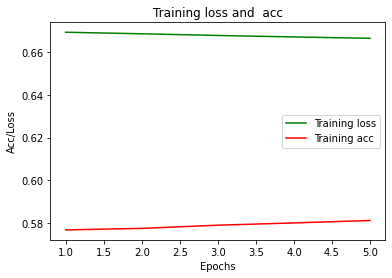

In [24]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, acc, 'r', label='Training acc')  
plt.title('Training loss and  acc')
plt.xlabel('Epochs')
plt.ylabel('Acc/Loss')
plt.legend()

* ROC曲线以及AUC值

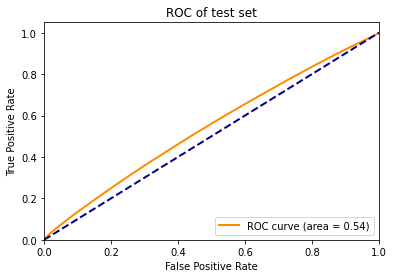

In [25]:
# 测试集
Y_test
Y_test_predict
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_test_predict, pos_label=1)
auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of test set')
plt.legend(loc="lower right")
plt.show()

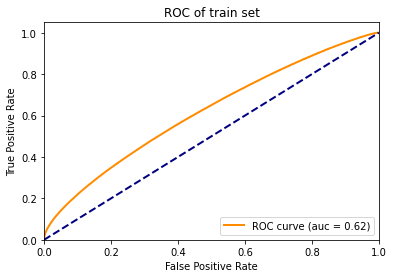

In [26]:
# 训练集
fpr, tpr, thresholds = metrics.roc_curve(Y_train, Y_train_predict, pos_label=1)
auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (auc = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of train set')
plt.legend(loc="lower right")
plt.show()

* f1-score

In [27]:
print(metrics.f1_score(Y_train, train_predict))
print(metrics.f1_score(Y_test, test_predict))

0.5637346683280064
0.5070766387897461


* 混淆矩阵

In [28]:
metrics.confusion_matrix(Y_train, train_predict)

array([[864619, 542373],
       [636169, 761446]])

In [29]:
metrics.confusion_matrix(Y_test, test_predict)

array([[372868, 278889],
       [320771, 308439]])

* 显示主要分类指标

In [30]:
print(metrics.classification_report(Y_train,train_predict))

              precision    recall  f1-score   support

         0.0       0.58      0.61      0.59   1406992
         1.0       0.58      0.54      0.56   1397615

    accuracy                           0.58   2804607
   macro avg       0.58      0.58      0.58   2804607
weighted avg       0.58      0.58      0.58   2804607



In [31]:
print(metrics.classification_report(Y_test,test_predict))

              precision    recall  f1-score   support

         0.0       0.54      0.57      0.55    651757
         1.0       0.53      0.49      0.51    629210

    accuracy                           0.53   1280967
   macro avg       0.53      0.53      0.53   1280967
weighted avg       0.53      0.53      0.53   1280967



## 5. 保存模型

In [32]:
model.save('./models/biClsModel_Test_D2.h5')

## 6. 保存预测结果

In [33]:
testResult.shape

(1280967, 6, 21)

In [34]:
testResult[:,-1,:2]

array([['2020-01-09', '000004.SZ'],
       ['2020-01-10', '000004.SZ'],
       ['2020-01-13', '000004.SZ'],
       ...,
       ['2021-07-28', '688600.SH'],
       ['2021-07-29', '688600.SH'],
       ['2021-07-30', '688600.SH']], dtype=object)

In [35]:
len(Y_test_predict)

1280967

In [36]:
pred_df = pd.DataFrame(testResult[:, -1, :2], columns = ['dt', 'kdcode'])

In [37]:
pred_df

,dt,kdcode
0,2020-01-09,000004.SZ
1,2020-01-10,000004.SZ
2,2020-01-13,000004.SZ
3,2020-01-14,000004.SZ
4,2020-01-15,000004.SZ
...,...,...
1280962,2021-07-26,688600.SH
1280963,2021-07-27,688600.SH
1280964,2021-07-28,688600.SH
1280965,2021-07-29,688600.SH


In [38]:
pred_df['score'] = Y_test_predict

In [39]:
pred_df

,dt,kdcode,score
0,2020-01-09,000004.SZ,0.449009
1,2020-01-10,000004.SZ,0.481999
2,2020-01-13,000004.SZ,0.484129
3,2020-01-14,000004.SZ,0.446306
4,2020-01-15,000004.SZ,0.442349
...,...,...,...
1280962,2021-07-26,688600.SH,0.658119
1280963,2021-07-27,688600.SH,0.520428
1280964,2021-07-28,688600.SH,0.439297
1280965,2021-07-29,688600.SH,0.394958


In [40]:
st_date = pred_df['dt'].min()
st_date

'2020-01-09'

In [41]:
dr = pd.date_range(st_date,'2021-7-20',freq='B') # 工作日
dr

DatetimeIndex(['2020-01-09', '2020-01-10', '2020-01-13', '2020-01-14',
               '2020-01-15', '2020-01-16', '2020-01-17', '2020-01-20',
               '2020-01-21', '2020-01-22',
               ...
               '2021-07-07', '2021-07-08', '2021-07-09', '2021-07-12',
               '2021-07-13', '2021-07-14', '2021-07-15', '2021-07-16',
               '2021-07-19', '2021-07-20'],
              dtype='datetime64[ns]', length=399, freq='B')

In [42]:
for date_i in tqdm(dr):
    dt = str(date_i.date())
    tmp_df = pred_df[pred_df['dt'] == dt]
    save_path = '../result4tiho/biClsModel_Test_D2/prediction/' + dt + '.csv'
    tmp_df.set_index(tmp_df['kdcode'])
    tmp_df.to_csv(save_path, index = False)

100%|██████████| 399/399 [00:25<00:00, 15.56it/s]
